#Demo de TF-Agents para BlackJack (21) usando DQN basado en los tutoriales de Tensor Flow:

Fuente: https://www.tensorflow.org/agents/tutorials/2_environments_tutorial

0) Preparar el ambiente:

In [1]:
#@title Instalar Paquete de TF-Agents
##!pip install -q tf-agents

# usar esta versión para evitar error 
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
!git checkout v0.13.0
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 5.2 MB/s 
     |████████████████████████████████| 18.3 MB 45 kB/s 
     |████████████████████████████████| 6.5 MB 33.0 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 5.8 MB 50.0 MB/s 
     |████████████████████████████████| 1.6 MB 47.7 MB/s 
     |████████████████████████████████| 438 kB 64.2 MB/s 
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully un

In [2]:
#@title Cargar Librerías
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from random import randint

from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment

from tf_agents.environments import utils
from tf_agents.specs import array_spec

from tf_agents.policies import random_tf_policy

from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.networks import q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")

Librerías cargadas.


1) Establecer las clases del Problema y del Agente:

In [11]:
#@title Definir Entorno del Problema 

# Un entorno que represente el juego podría verse así:
##Acciones: Tenemos 2 acciones. 
##             Acción 0: obtener una nueva carta 
##             Acción 1: terminar la ronda actual.
##Observaciones: Suma de las cartas de la ronda actual.
##Recompensa: El objetivo es acercarse lo más posible a 21 sin pasarse, 
##            por lo que podemos lograrlo usando la siguiente recompensa al final de la ronda: 
##            suma_de_tarjetas - 21 si suma_de_tarjetas <= 21, de lo contrario -21
class CardGameEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state, 0], dtype=np.int32))

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # Aplica la acción
    if action == 1:
      # indica no seguir jugando
      self._episode_ended = True
      new_card = 0
    elif action == 0:
      # solicita una carta
      new_card = randint(1, 12)
      if new_card == 1:
        # el as puede valer 1 o 11
        if (self._state + 11) < 21:
          self._state = self._state + 11
        else:
          self._state = self._state + 1  
      elif new_card >= 10:
        # las figuras valen 10
        self._state = self._state + 10
      else:
        # el resto vale su valor
        self._state = self._state + new_card
      # se llega a un valor de 21, no se puede pedir más
      if self._state >= 21:
        self._episode_ended = True
    else:
      raise ValueError('La acción debe ser 0 o 1.')

    # finaliza 
    if self._episode_ended:
      # si finaliza
      # determina el reward (siempre se maximiza)
      # en este caso el máximo es 21!
      if self._state > 21:
        # se paso de 21, devuelve cantidad que se paso (negativo)
        reward = 21 - self._state 
      else:
        # no se paso de 21 (devuelve a donde llegó)
        reward = self._state 
      return ts.termination(np.array([self._state, new_card], dtype=np.int32), reward)
    else:
      # si no finaliza
      return ts.transition(
          np.array([self._state, new_card], dtype=np.int32), reward=0.0, discount=0.9)


print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = CardGameEnv()
eval_py_env = CardGameEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")


# definir simulador para probar el entorno
def SimularEntorno(eval_env, policy, titulo, num_episodes=1, mostrarDetalleStep=True):
    if num_episodes <=0:
      num_episodes = 1    
    # inicializa acumulador auxiliar 
    cumulative_reward_total = 0.0    
    print("\n** ", titulo, "**")                   
    for i in range(num_episodes):
      if num_episodes>1:
        print("\n> Episodio ", i+1, ": ")
      # muesta estado inicial
      time_step = eval_env.reset()  
      ob = time_step.observation.numpy()[0]
      if mostrarDetalleStep:
        print(" Ini: estado ", ob[0], "[", time_step, "]")      
      else:
        print(" Ini: estado ", ob[0])      
      j = 1
      while not time_step.is_last():
        # la política determina la acción a realizar
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        # recupera la observación y muestra el nuevo estado 
        ob = time_step.observation.numpy()[0]
        if ob[1] == 0:
          descAccion = "decide no pedir más cartas"
        else:
          descAccion = "sale carta " + str( ob[1] )
        if mostrarDetalleStep:
          print(" #", j, ": ", descAccion, "-> estado: ", ob[0], "[", time_step, "]")
        else:
          print(" #", j, ": ", descAccion, "-> estado: ", ob[0])
        j = j + 1
        
      # muestra estado final
      ob = time_step.observation.numpy()[0]
      r = time_step.reward.numpy()
      if mostrarDetalleStep:
        print(" Fin -> estado ", ob[0], "[", time_step, "]")
      else:
        print(" Fin -> estado ", ob[0])
      print(' Recompensa final = ', r[0])
      cumulative_reward_total += r[0]
    if num_episodes > 1:
      promedioEpisodios = round(cumulative_reward_total/num_episodes,3)
      print("\n= Recompensa Promedio Total: ", promedioEpisodios, "\n")
      return promedioEpisodios
    else:
      return cumulative_reward_total

print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostarDetalleSteps = False #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema al azar", MostarDetalleSteps)


Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar **
 Ini: estado  0 [ TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[0, 0]], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>}) ]
 # 1 :  sale carta 7 -> estado:  7 [ TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[7, 7]], dtype=int32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}) ]
 # 2 :  sale carta 2 -> estado:  9 [ TimeStep(
{'discount': <tf.T

In [4]:
#@title Definir el Agente tipo DQN

learning_rate = 1e-3  # @param {type:"number"}
cant_neuronas_ocultas = 100 # @param {type:"integer"}
if cant_neuronas_ocultas < 10:
  cant_neuronas_ocultas = 10

# Define cantidad de neuronas ocultas para RNA-Q
fc_layer_params = (cant_neuronas_ocultas,)

# Define RNA-Q
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

# Define el agente de tipo Q
ag = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

ag.initialize()

# define política para evaluación para el Agente
eval_policy = ag.policy

# define política para recolección de datos para el Agente
collect_policy = ag.collect_policy

print("Agente DQN inicializado. ")

Agente DQN inicializado. 


In [5]:
#@title Definir Métricas para evaluación

# Se usa el promedio de la recompensa (la más común)
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

print("Métricas definidas.")

Métricas definidas.


3) Llevar a cabo el Entrenamiento:

In [6]:
#@title Preparar datos para Entrenamiento

initial_collect_steps = 500  # @param {type:"integer"} 
collect_steps_per_iteration = 10  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}
batch_size = 64  # @param {type:"integer"}


# Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec = ag.collect_data_spec,
    batch_size = train_env.batch_size,
    max_length = replay_buffer_max_length)

# Recolecta datos generados al azar
# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

print("\nDatos recolectados.")

# Muestra ejemplo de los datos recolectados
##iter(replay_buffer.as_dataset()).next()

# Preparar los datos recolectados con trajectories de shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)
iterator = iter(dataset)
# Muestra ejemplo 
##iterator.next()
print("\nDataset creado.")


Datos recolectados.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.

Dataset creado.


In [7]:
#@title Entrenar al Agente

cant_ciclos_entrenamiento = 5000 # @param {type:"integer"}
log_cada_ciclos = 200  # @param {type:"integer"}
evaluar_cada_ciclos = 1000  # @param {type:"integer"}
cant_episodios_evaluacion = 25  # @param {type:"integer"}


#  Optimize by wrapping some of the code in a graph using TF function (Optional)
ag.train = common.function(ag.train)

# Reset the train step
ag.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
ar_ciclo = []
ar_returns = []
ar_loss = []

print("\n** Comienza el Entrenamiento **\n")
for _ in range(cant_ciclos_entrenamiento):

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_data(train_env, ag.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = ag.train(experience).loss

  step = ag.train_step_counter.numpy()

  if (step == 1) or (step % log_cada_ciclos == 0):
    print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
    ar_ciclo.append( step )
    ar_loss.append( train_loss )
    avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
    ar_returns.append( avg_return )

    if (step == 1) or (step % evaluar_cada_ciclos == 0):
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

print("\n** Entrenamiento Finalizado **\n")



** Comienza el Entrenamiento **

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1: loss = 15.014
step = 1: Promedio Recompensa = 7.0
step = 200: loss = 31.074
step = 400: loss = 20.185
step = 600: loss = 11.304
step = 800: loss = 11.779
step = 1000: loss = 10.153
step = 1000: Promedio Recompensa = 14.4
step = 1200: loss = 17.340
step = 1400: loss = 2.426
step = 1600: loss = 4.936
step = 1800: loss = 5.060
step = 2000: loss = 9.391
step = 2000: Promedio Recompensa = 15.4
step = 2200: loss = 2.585
step = 2400: loss = 4.023
step = 2600: loss = 10.948
step = 2800: loss = 3.371
step = 3000: loss = 10.099
step = 3000: Promedio Recompensa = 15.9
step = 3200: loss = 2.682
step = 3400: loss = 2.073
step = 3600: loss = 7.876
step = 3800: loss = 2.011
step = 4000: loss = 6.237
step = 4000: Promedio Recomp

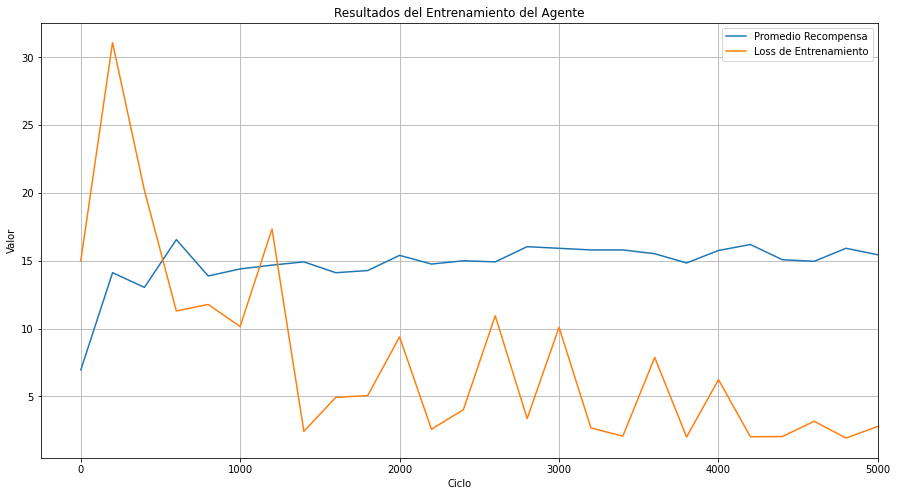

In [8]:
#@title Mostrar Gráficos del Entrenamiento

plt.figure(figsize=(15,8)) 
plt.plot( ar_ciclo, ar_returns)
plt.plot( ar_ciclo, ar_loss )
plt.title("Resultados del Entrenamiento del Agente")
plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
plt.ylabel('Valor')
plt.xlabel('Ciclo')
plt.xlim(right=max(ar_ciclo))   
##plt.ylim(top=21)    
plt.grid(True)
plt.show()


4) Probar entrenamiento comparando resultados:

In [9]:
#@title Probar el Agente Entrenado contra el Azar
cantidad_partidas_probar = 5 # @param {type:"integer"}
promAzar = 0
promAgente = 0

for i in range(cantidad_partidas_probar):

  print("\n> Partida ", i+1, ":")

  # Probar Aleatorio
  valorAzar = SimularEntorno(eval_env, random_policy, "Resultados Aleatorio", 1, False) 
  promAzar = promAzar + valorAzar

  # Probar Agente Entrenado
  valorAgente = SimularEntorno(eval_env, ag.policy, "Resultados de Agente Entrenado", 1, False) 
  promAgente = promAgente + valorAgente

  # Decide Ganador
  if (valorAgente <= 21 and valorAzar < valorAgente) or (valorAzar > 21):
    print("\n--> GANA el Agente Entrenado (", valorAgente,") contra el azar (", valorAzar,")")
  else:
    print("\n--> PIERDE el Agente Entrenado (", valorAgente,") contra el azar (", valorAzar,")")


# Decide Ganador General
if cantidad_partidas_probar > 0:
  promAgente = promAgente / cantidad_partidas_probar
  promAzar = promAzar / cantidad_partidas_probar
  print("\n================================================================================================\n")
  if (promAgente <= 21 and promAzar < promAgente) or (promAzar > 21):
    print("= En promedio GANA el Agente Entrenado (", promAgente,") contra el azar (", promAzar,")")
  else:
    print("= En promedio PIERDE el Agente Entrenado (", promAgente,") contra el azar (", promAzar,")")
  print("\n================================================================================================\n")


> Partida  1 :

**  Resultados Aleatorio **
 Ini: estado  0
 # 1 :  sale carta 8 -> estado:  8
 # 2 :  decide no pedir más cartas -> estado:  8
 Fin -> estado  8
 Recompensa final =  8.0

**  Resultados de Agente Entrenado **
 Ini: estado  0
 # 1 :  sale carta 8 -> estado:  8
 # 2 :  sale carta 2 -> estado:  10
 # 3 :  sale carta 4 -> estado:  14
 # 4 :  decide no pedir más cartas -> estado:  14
 Fin -> estado  14
 Recompensa final =  14.0

--> GANA el Agente Entrenado ( 14.0 ) contra el azar ( 8.0 )

> Partida  2 :

**  Resultados Aleatorio **
 Ini: estado  0
 # 1 :  decide no pedir más cartas -> estado:  0
 Fin -> estado  0
 Recompensa final =  0.0

**  Resultados de Agente Entrenado **
 Ini: estado  0
 # 1 :  sale carta 10 -> estado:  10
 # 2 :  sale carta 10 -> estado:  20
 # 3 :  decide no pedir más cartas -> estado:  20
 Fin -> estado  20
 Recompensa final =  20.0

--> GANA el Agente Entrenado ( 20.0 ) contra el azar ( 0.0 )

> Partida  3 :

**  Resultados Aleatorio **
 Ini: est

In [21]:
#@title Probar Agente Entrenado contra Usuario Humano (notar que el agente no considera cartas del humano)
import ipywidgets as widgets
from IPython.display import display, clear_output

# Crea los entornos
agent_env = tf_py_environment.TFPyEnvironment( CardGameEnv() )
human_env = tf_py_environment.TFPyEnvironment( CardGameEnv() )

def resetear(env):
  # reinicia la jugada
  time_step = env.reset()  
  ob = time_step.observation.numpy()[0]
  return 1, time_step

def jugar(prefijoJugador, nombreJugador, env, paso, action):
  if paso < 0:
    # no se hace porque ya termino la partida
    return paso
  else:
    # aplica la acción
    time_step = env.step(action)
    # recupera la observación y muestra el nuevo estado 
    ob = time_step.observation.numpy()[0]
    if ob[1] == 0:
      descAccion = "decide no pedir más cartas"
    else:
      descAccion = "sale carta " + str( ob[1] )
    print(prefijoJugador, " Juega ", nombreJugador, " #", paso, ": ", descAccion, "-> suma: ", ob[0]) #, "[", time_step, "]")        
    # ve si termino o sigue
    if time_step.is_last():
      paso = -1
    else:
      paso = paso + 1
    return paso, time_step

# define funciones para los botones
def on_buttonR_clicked(b):
  global i, j, ag, agent_env, ag_time_step, human_env, human_time_step
  # se toca botón para reiniciar la partida
  with output:
    clear_output()
    print("\n> Nueva Partida:\n")
    # inica jugando primero el agente
    i, ag_time_step = resetear(agent_env)
    ag_action_step = ag.policy.action(ag_time_step)
    i, ag_time_step = jugar("*", "Agente", agent_env, i, ag_action_step.action)
    # resetea el humano
    j, human_time_step = resetear(human_env)
    # fuerza que le de la primera carta al humano
    on_button0_clicked(button0)
  # muestra botones
  display(button0, button1, buttonR, output)

def on_button0_clicked(b):
  global i, j, ag, agent_env, ag_time_step, human_env, human_time_step
  # se toca botón de pedir nueva carta
  with output:
    # juega humano
    if j >= 0:
      j, human_time_step = jugar("+", "Humano", human_env, j, np.array(0, dtype=np.int32))
    # juega agente entrenado
    while i >= 0 :
      ag_action_step = ag.policy.action(ag_time_step)
      i, ag_time_step = jugar("*", "Agente", agent_env, i, ag_action_step.action)
      if j >= 0:
        # si el humano no terminó, lo hace jugar una vez solamente
        break
    # si ambos finalizaron, muestra el estado final
    if i < 0 and j < 0:
      mostrarEstadoFinal(ag_time_step, human_time_step)

def on_button1_clicked(b):
  global i, j, ag, agent_env, ag_time_step, human_env, human_time_step
  # se toca botón de finalizar partida (plantarse)
  with output:
    # juega humano
    if j >= 0:
      j, human_time_step = jugar("+", "Humano", human_env, j, np.array(1, dtype=np.int32))
    # juega agente entrenado
    while i >= 0 :
      ag_action_step = ag.policy.action(ag_time_step)
      i, ag_time_step = jugar("*", "Agente", agent_env, i, ag_action_step.action)
    # muesta el estado final
    mostrarEstadoFinal(ag_time_step, human_time_step)
    print("\n")

def mostrarEstadoFinal(ag_time_step, human_time_step):
    ag_r = int(ag_time_step.reward.numpy()[0])
    ag_h = int(human_time_step.reward.numpy()[0])
    # muestra estado final
    if (ag_r <= 21 and ag_h < ag_r) or (ag_h > 21):
      print("\n--> GANA el Agente Entrenado (", ag_r,") contra el Humano (", ag_h,")")
    else:
      print("\n--> PIERDE el Agente Entrenado (", ag_r,") contra el Humano (", ag_h,")")
    print("\n")          
    return

# define botones
button0 = widgets.Button(description="Dame Otra Carta")
button1 = widgets.Button(description="Plantarse")
buttonR = widgets.Button(description="Reiniciar Partida")
output = widgets.Output()
buttonR.on_click(on_buttonR_clicked)
button1.on_click(on_button1_clicked)
button0.on_click(on_button0_clicked)    

# comienza a jugar
i, j = 0, 0
on_buttonR_clicked(buttonR)



Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()

Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()

Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()